<a href="https://colab.research.google.com/github/Doppler-67/trade_bot/blob/main/long_rsi_macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#!pip install talib-binary

In [47]:
#!pip install yfinance

In [48]:
import talib as tb
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf

In [49]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [50]:
data = yf.download('ETH-USD', interval = '2m', period = '60d').reset_index()
data = data.drop(['Adj Close', 'Volume'], axis =1)
data.columns = data.columns.str.lower()
data['rsi'] = tb.RSI(data['close'])
data['macd'], data['macd_signal'], data['macd_hist'] = tb.MACD(data['close'])
#data['ema200'] = tb.EMA(data['close'], 200) 
data = data.dropna().reset_index(drop = True)
#data['ema200'] = tb.EMA(data['close'], 200) #
#data = data.fillna(666) #

[*********************100%***********************]  1 of 1 completed


In [51]:
data.head()

,datetime,open,high,low,close,rsi,macd,macd_signal,macd_hist
0,2022-04-23 01:06:00+00:00,2958.245850,2958.270264,2958.245850,2958.270264,41.773925,-2.323256,-2.805360,0.482104
1,2022-04-23 01:08:00+00:00,2958.205566,2958.549072,2958.205566,2958.549072,43.149027,-2.168434,-2.677975,0.509541
2,2022-04-23 01:10:00+00:00,2959.605225,2959.605225,2959.605225,2959.605225,48.144927,-1.938171,-2.530014,0.591843
3,2022-04-23 01:12:00+00:00,2959.384521,2959.384521,2957.930420,2957.930420,41.862552,-1.869281,-2.397867,0.528586
4,2022-04-23 01:14:00+00:00,2957.645996,2957.820068,2957.645996,2957.820068,41.478496,-1.802808,-2.278855,0.476048


In [52]:
def find_buy_signal(start, df):
    rsi_min = 30
    for i in range(start, len(df) - 1):
        if df.iloc[i]['rsi'] <= rsi_min:
            for j in range(i, len(df)):
                if df.iloc[j-1]['macd_hist'] < 0 and df.iloc[j]['macd_hist'] > 0: # > 0
                    return j+1
    return -1

In [53]:
def find_buy_signal(start, df): # upgraded version
    rsi_min = 30
    candles_amount = 10
    for i in range(start, len(df)):
        if df.iloc[i-1]['macd_hist'] < 0 and df.iloc[i]['macd_hist'] > 0:
            for j in range(i, i-candles_amount, -1):
                if df.iloc[j]['rsi'] <= rsi_min:
                    return i+1
    return -1

In [54]:
def find_sell_signal(start, df, sl, tp):
    for i in range(start, len(df) - 1):
        if tp <= df.iloc[i]['high']: # tp triggered
            return i+1, 1
        elif sl >= df.iloc[i]['low']: # sl triggered
            return i+1, 0 
        #elif df.iloc[i]['macd_hist'] < 0 or df.iloc[i]['rsi'] >= 85: # combo broke
        #    return i+1, 666
        elif df.iloc[i]['rsi'] >= 80: #
            return i+1, 666 #
    return -1, -1

In [55]:
def long_homyak_bot(df):
    money = 1000
    tp = 1 + 1.5 / 100 # 1 + x / 100, where x is any percent number
    sl = 1 - 0.5 / 100 # 1 - x / 100, where x is any percent number
    buy_price = 0
    sell_price = 0
    start = 10
    plus = 0
    minus = 0
    plot_money = ([])

    while True:
        plot_money.append(money)
        buy_signal_index  = find_buy_signal(start,df) # find buy price
        if buy_signal_index != -1: #  if buy signal exists
            buy_price = df.iloc[buy_signal_index]['open'] # calculating buy price 
            tp_price = buy_price * tp
            sl_price = buy_price * sl # calculating sl
            sell_signal_index, reason = find_sell_signal(buy_signal_index, df, sl_price, tp_price) # find sell price
            if sell_signal_index != -1: #if sell signal exists
                if reason == 1: # if tp triggered
                    sell_price = tp_price # sell price will be tp price
                    #print('tp triggered') #
                elif reason == 0: # if sl triggered
                    sell_price = sl_price # sell price will be sl price
                    #print('sl triggered')
                else:
                    sell_price = df.iloc[sell_signal_index]['open']
                    
                if sell_price > buy_price:#
                    plus +=1#
                else:#
                    minus +=1#
                money = money * (sell_price / buy_price)
                start = sell_signal_index
                # debug prints
                #print(buy_signal_index,df.iloc[buy_signal_index]['datetime'],f' buy price: {buy_price}, tp: {tp_price}, sl: {sl_price}')
                #print(sell_signal_index,df.iloc[sell_signal_index]['datetime'],f' sell price: {sell_price}', '\n')
            else:
                break
          
        else:
            break
    plot_money = pd.DataFrame(plot_money, columns = ['balance'])
    plot_money['trade'] = plot_money.index + 1
    print(f'кол-во прибыльных трейдов {plus}, а убыточных {minus}')#        
    print(money)
    sns.lineplot(data=plot_money, x ='trade', y ='balance')

кол-во прибыльных трейдов 86, а убыточных 138
1216.3656979819134


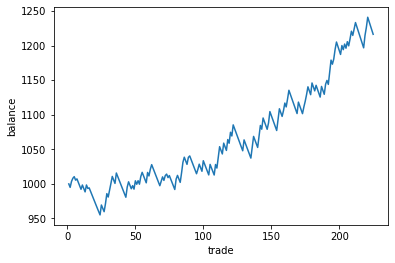

In [56]:
long_homyak_bot(data)